# Rasterio

## Intro

## Summary
- reproject (warp)
- mosaic
- clip
- vectorize

# Setup

In [37]:
import rasterio as rio
import rioxarray as rioxr
from rioxarray.merge import merge_arrays

import numpy as np

# Read

In [38]:
# http://www.dsr.inpe.br/topodata/acesso.php
tile_1 = rioxr.open_rasterio('zip+http://www.dsr.inpe.br/topodata/data/geotiff/22S465ZN.zip!/22S465ZN.tif')
tile_2 = rioxr.open_rasterio('zip+http://www.dsr.inpe.br/topodata/data/geotiff/23S465ZN.zip!/23S465ZN.tif')
tile_3 = rioxr.open_rasterio('zip+http://www.dsr.inpe.br/topodata/data/geotiff/22S48_ZN.zip!/22S48_ZN.tif')
tile_4 = rioxr.open_rasterio('zip+http://www.dsr.inpe.br/topodata/data/geotiff/23S48_ZN.zip!/23S48_ZN.tif')

## Reproject

In [39]:
tile_1.rio.write_crs('epsg:4326', inplace = True)
tile_2.rio.write_crs('epsg:4326', inplace = True)
tile_3.rio.write_crs('epsg:4326', inplace = True)
tile_4.rio.write_crs('epsg:4326', inplace = True)

<xarray.DataArray (band: 1, y: 3600, x: 5400)>
[19440000 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -48.0 -48.0 -48.0 -48.0 ... -46.5 -46.5 -46.5 -46.5
  * y            (y) float64 -23.0 -23.0 -23.0 -23.0 ... -24.0 -24.0 -24.0 -24.0
    spatial_ref  int32 0
Attributes:
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        IDRISI KILIMANJARO
    TIFFTAG_XRESOLUTION:     87.699997
    TIFFTAG_YRESOLUTION:     87.699997
    scale_factor:            1.0
    add_offset:              0.0

## Mosaic

In [40]:

# Merge/Mosaic multiple rasters using merge_arrays method of rioxarray
merged_raster = rioxr.merge.merge_arrays(dataarrays = [tile_1, tile_2, tile_3, tile_4],
                                        #  res = (90, 90),
                                         crs="EPSG:4326",
                                        nodata = 0
                                         )
 
# Save Raster to disk
merged_raster.rio.to_raster("../data/tmp/merged.tiff")

CPLE_AppDefinedError: Deleting ../data/tmp/merged.tiff failed: Permission denied

In [ ]:
# path = "../data/tmp/merged.tiff"
# ds = rioxr.open_rasterio(path).squeeze()
# img = ds.plot(cmap="Greys", add_colorbar=False)

## Clip
- https://carpentries-incubator.github.io/geospatial-python/08-crop-raster-data/index.html

In [41]:
path = "../data/tmp/merged.tiff"
ds = rioxr.open_rasterio(path)

In [42]:
from matplotlib import pyplot as plt
import geopandas as gpd
df_jaguari_basin = gpd.read_file('../data/vector/ide_0102_pj_otto_bacia_pol.zip')
# Filter the drainage area of Jaguari river
df_jaguari_basin = df_jaguari_basin[df_jaguari_basin['nunivotto5'].isin(['86669'])].dissolve()
# df_jaguari_basin.to_file('../data/tmp/jaguari_basin.shp')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

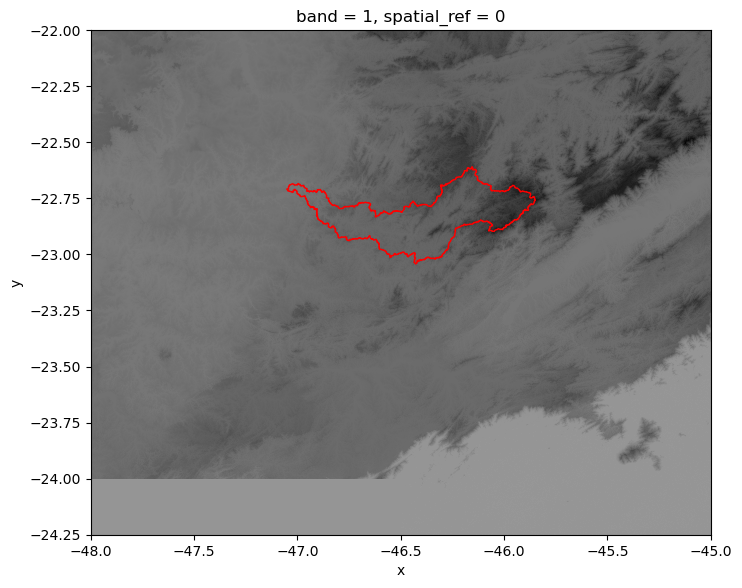

In [43]:
# Convert the coordinate system
df_jaguari_basin = df_jaguari_basin.to_crs(ds.rio.crs)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches((8,8))

# Plot image
ds.plot(ax=ax,cmap="Greys", add_colorbar=False)

# Plot crop fields
df_jaguari_basin.plot(
    ax=ax,
    edgecolor="red",
    facecolor="none"
)

In [44]:
mde_clip = ds.rio.clip(df_jaguari_basin['geometry'])

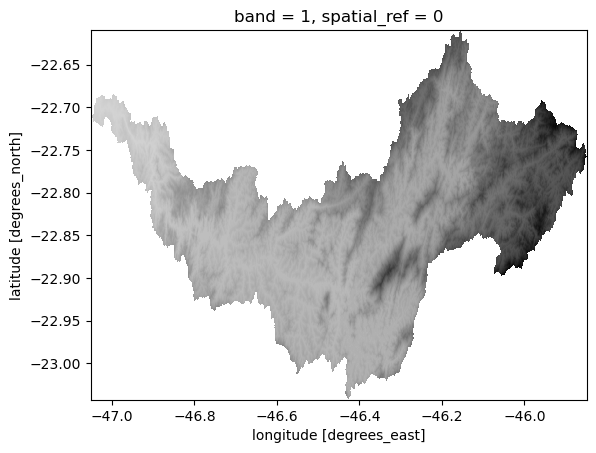

In [45]:
img = mde_clip.plot(cmap="Greys", add_colorbar=False)

## Vectorize

In [46]:
mde_clip

<xarray.DataArray (band: 1, y: 1559, x: 4329)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -47.05 -47.05 -47.05 ... -45.85 -45.85 -45.85
  * y            (y) float64 -22.61 -22.61 -22.61 ... -23.04 -23.04 -23.04
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        IDRISI KILIMANJARO
    TIFFTAG_XRESOLUTION:     87.699997
    TIFFTAG_YRESOLUTION:     87.699997
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0.0

In [ ]:
# Função para poligonizar raster
def polygonize(raster_file):
  img = gdal.Open(raster_file)
  dn = img.GetRasterBand(1)
  shp_driver = ogr.GetDriverByName("ESRI Shapefile")

  shape_out = shp_driver.CreateDataSource('segs.shp')
  srs = ogr.osr.SpatialReference()
  srs.ImportFromEPSG(32723)
  novo_shape = shape_out.CreateLayer('segs.shp', srs = srs)
  gdal.Polygonize(dn, None, novo_shape, -1, [], callback=None)
  shape_out.Destroy()
  return print('Polígonos criados!')

In [ ]:
gpd_polygonized_raster = gpd.GeoDataFrame()
for i, path in enumerate(glob.glob('*.tif')):
    with rio.open(path) as src:
        print('abrindo arquivo {}: {} '.format(i, path), '\n')
        print(src.profile, '\n')
    
        clipped_image, image_transform = mask(src, br_lim.geometry, crop = True)
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v)  in enumerate(shapes(clipped_image, mask=clipped_image>0, transform=image_transform
                                                )) 
        )
        #src.close()
                
    #The result is a generator of GeoJSON features
    print('Transformando em vetor', '\n')
    geoms = list(results)
    #Create geopandas Dataframe and enable easy to use functionalities of spatial join, plotting, save as geojson, ESRI shapefile etc. 
    gpd_polygonized_raster = pd.concat([gpd_polygonized_raster,gpd.GeoDataFrame.from_features(geoms)])

print('Salvando arquivo .shp')

gpd_polygonized_raster.crs = "EPSG:4326"
gpd_polygonized_raster.to_file('GLAD_br_{}.shp'.format(data.replace('/', '_')))